_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens, Dr. Alexander Ecker

Tutors: Sarah Strauss, Santiago Cadena

Summer term 2019

Due date: 2019-07-02, 9am

Name: Shanqian Ma:{1,2}, Weiyi Xiao:{3,4}

# Exercise sheet 7



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.optimize as opt
import scipy.io as io
import scipy as sp

from sklearn.datasets import make_checkerboard as checkerboard

mpl.rc("savefig", dpi=72)

import itertools

sns.set_style('whitegrid')
%matplotlib inline

## Task 1: Fit RF on simulated data

We will start  with toy data generated from an LNP model neuron to make sure everything works right. The model LNP neuron consists of one Gaussian linear filter, an exponential nonlinearity and a Poisson spike count generator. We look at it in discrete time with time bins of width $\delta t$. The model is:

$$
c_t \sim Poisson(r_t)\\
r_t = \exp(w^T s_t) \cdot \Delta t \cdot R
$$

Here, $c_t$ is the spike count in time window $t$ of length $\Delta t$, $s_t$ is the stimulus and $w$ is the receptive field of the neuron. The receptive field variable `w` is 15 × 15 pixels and normalized to $||w||=1$. A stimulus frame is a 15 × 15 pixel image, for which we use uncorrelated checkerboard noise. R can be used to bring the firing rate into the right regime (e.g. by setting $R=50$).   

For computational ease, we reformat the stimulus and the receptive field in a 225 by 1 array. The function ```sampleLNP``` can be used to generate data from this model. It returns a spike count vector `c` with samples from the model (dimensions: 1 by nT = $T/\Delta t$), a stimulus matrix `s` (dimensions: 225 × nT) and the mean firing rate `r` (dimensions: nT × 1). 

Here we assume that the receptive field influences the spike count instantaneously just as in the above equations. Implement a Maximum Likelihood approach to fit the receptive field. 

To this end simplify and implement the log-likelihood function $L(w)$ and its gradient $\frac{L(w)}{dw}$ with respect to $w$ (`logLikLnp`). The log-likelihood of the model is
$$L(w) = \log \prod_t \frac{r_t^{c_t}}{c_t!}\exp(-r_t).$$

Plot the true receptive field, a stimulus frame, the spike counts and the estimated receptive field. 

*Grading: 2 pts (calculations) + 3 pts (implementation)*


### Calculations




<img src="calculations.jpg" align="left" width=600 height=600 />

### Generate data

In [2]:
def gen_gauss_rf(D,width, center=(0,0)):
    
    # generates a Gaussian blob as an image
    
    sz = (D-1)/2
    x, y = sp.mgrid[-sz: sz + 1, -sz: sz + 1]
    x = x + center[0]
    y = y + center[1]
    w = sp.exp(- (x ** 2/width + y ** 2 / width))
    w = w/np.sum(w.flatten()) #normalization
    
    return w

In [40]:
def sampleLnp(w, nT, dt, R, v):
    '''
    Generate samples from an instantaneous LNP model neuron with 
    receptive field kernel w.
    
    Arguments:
        w:  receptive field kernel
        nT: number of time steps
        dt: duration of a frame in s
        R:  rate parameter
        v:  variance of the stimulus ensemble
    
    Returns:
        c:  sampled spike counts in time bins
        r:  mean rate in time bins
        s:  stimulus frames used
        
    See equations in task description above for a precise definition
    of the individual parameters.
    '''
    
    # np.random.seed(10) 
    'since need generate 1000 times of checkerboard, so could not maintain random state'
    
    # ENTER YOUR CODE HERE
    
    s=np.zeros([D*D,nT])
    for i in range (nT):
        data,row,col=checkerboard(shape=(D, D), n_clusters=(15,15),minval=0,maxval=1, noise=np.sqrt(v), shuffle=False)
        s[:,i]=data.flatten()
    r = np.exp(w@s)*dt*R
    c = np.random.poisson(r)
        
        
    return c, r, s

In [41]:

D = 15     # number of pixels
nT = 1000  # number of time bins
dt = 0.1   # bins of 100 ms
R = 50     # firing rate in Hz 
v = 5      #stimulus variance

w = gen_gauss_rf(D,7,(1,1))
w = w.flatten()

c, r, s = sampleLnp(w, nT, dt, R, v)
print(np.shape(s))

(225, 1000)


Plot the responses of the cell.

Text(0, 0.5, 'spike count')

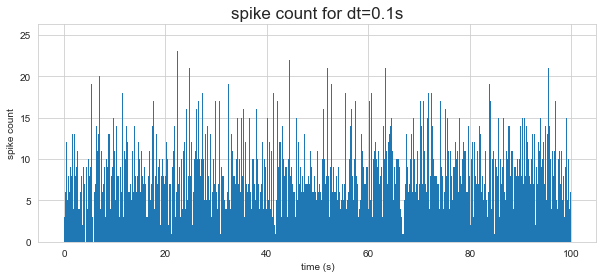

In [42]:
plt.figure(figsize=(10,4))

t = np.arange(0,nT) * dt
plt.bar(t,c,width=dt,linewidth=0)
plt.title('spike count for dt=0.1s',fontsize=17)
plt.xlabel('time (s)')
plt.ylabel('spike count')

### Implementation 

Before you run your optimizer, make sure the gradient is correct. The helper function `check_grad` in `scipy.optimize` can help you do that. This package also has suitable functions for optimization. If you generate a large number of  samples, the fitted receptive field will look more similar to the true receptive field. With more samples, the optimization takes longer, however.

In [43]:
def logLikeLnp(x, c, s):
    '''
      Plot spike rasters for a single neuron sorted by condition

      f, df = logLikLnp(x,c,s)
       Implements the negative (!) log-likelihood of the LNP model and its
       gradient with respect to the receptive field w.

       x   current receptive field (225 x 1)
       c   spike counts (1 x T/dt)
       s   stimulus matrix (225 x T/dt)

       f   function value of the negative log likelihood at x (scalar)
       df  gradient of the negative log likelihood with respect to x (225 x 1)

    '''
    r = np.exp(x@s)*dt*R
    
    #need negative loglikelihhod
    f=-sum(c*np.log(r)-np.log(sp.special.factorial(c))-r)
    df=-(s@c-s@r)
            
    return f, df


In [44]:
func,grad=logLikeLnp(w, c, s)
print(func)
print(np.shape(grad))

2465.2300918566966
(225,)


Fit receptive field maximizing the log likelihood

In [45]:
# enter optimization code here
def func(x):
    return logLikeLnp(x, c, s)[0]
def grad(x):
    return logLikeLnp(x, c, s)[1]

checkpts = np.random.uniform(0,1,D*D)
checkpts = checkpts/sum(checkpts)

print('To check the gradient, the result is:', opt.check_grad(func,grad,checkpts))

w_estimated = opt.minimize(logLikeLnp, x0=checkpts,args=(c,s), jac=True,options={'disp': True})

To check the gradient, the result is: 0.00879048116063611
Optimization terminated successfully.
         Current function value: 2367.610692
         Iterations: 251
         Function evaluations: 427
         Gradient evaluations: 427


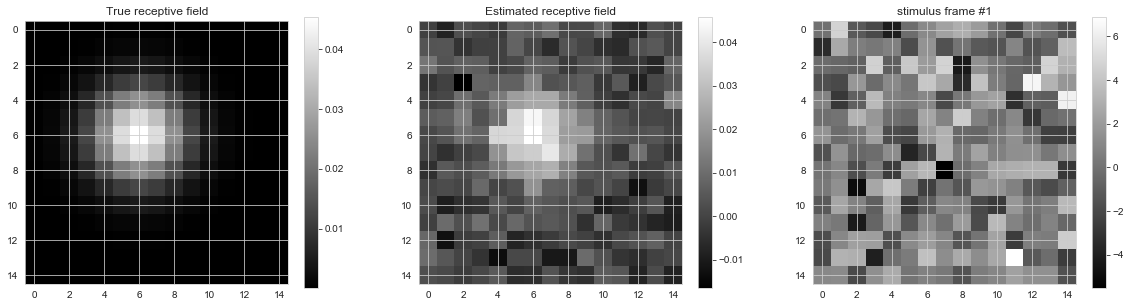

In [48]:
# enter comparison true/estimated here
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.imshow(np.reshape(w, (D,D)),cmap='gray')  
plt.colorbar()
plt.title('True receptive field')

plt.subplot(1,3,2)
plt.imshow(np.reshape(w_estimated.x, (D,D)),cmap='gray')  
plt.colorbar()
plt.title('Estimated receptive field')

plt.subplot(1,3,3)
plt.imshow(np.reshape(s[:,0], (D,D)),cmap='gray')  
plt.colorbar()
plt.title('stimulus frame #1')

plt.show()

## Task 2: Apply to real neuron

Download the dataset for this task from Ilias (`nda_ex_6_data.mat`). It contains a stimulus matrix (`s`) in the same format you used before and the spike times. In addition, there is an array called `trigger` which contains the times at which the stimulus frames were swapped.

* Generate an array of spike counts at the same temporal resolution as the stimulus frames
* Fit the receptive field with time lags of 0 to 4 frames. Fit them one lag at a time (the ML fit is very sensitive to the number of parameters estimated and will not produce good results if you fit the full space-time receptive field for more than two time lags at once). 
* Plot the resulting filters

*Grading: 2 pts*


In [11]:
var = io.loadmat('data\\nda_ex_6_data.mat')

# t contains the spike times of the neuron
t = var['DN_spiketimes'].flatten()    

# trigger contains the times at which the stimulus flipped
trigger = var['DN_triggertimes'].flatten()

# contains the stimulus movie with black and white pixels
s2 = var['DN_stim']
print(s2.shape)
s2 = s2.reshape((300,1500))
ss = s2[:,1:len(trigger)]


(20, 15, 1500)


Create vector of spike counts

In [12]:
cc, b = np.histogram(t,bins=trigger)

Fit receptive field for each frame separately

In [13]:
rand_RF = np.random.uniform(low=0, high=1, size=300)
x0 = rand_RF/np.sum(rand_RF)

time_lag=np.arange(0,5)

# when time lag is 0 frame
w_est=[]
w_est.append(opt.minimize(logLikeLnp, x0,args=(cc[:],ss[:,:]), jac=True,options={'disp': False}).x)

for i in range(1,5):
    # use the update s and c
    w_est.append(opt.minimize(logLikeLnp, x0, args=(cc[i:],ss[:,:-i]), jac=True,options={'disp': False}).x)
    

Plot the frames one by one

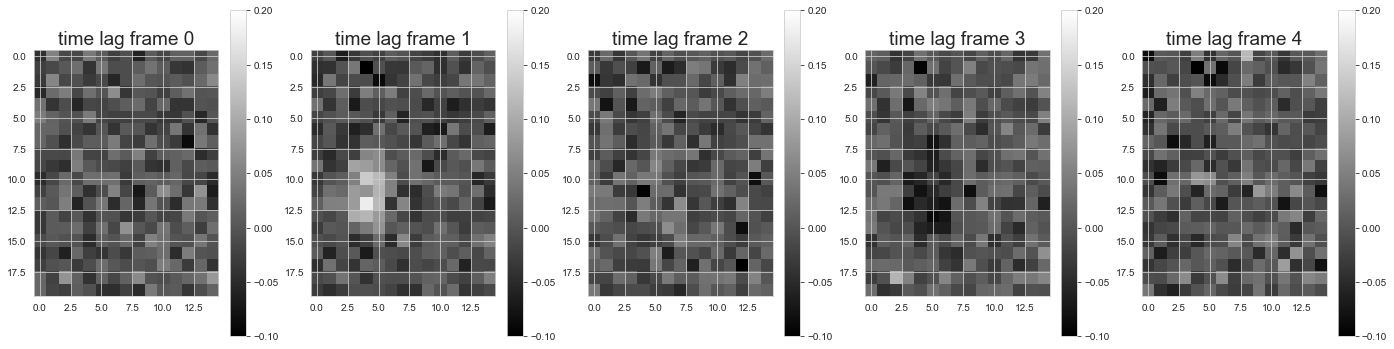

In [49]:
plt.figure(figsize=(24,6))
for i in time_lag:
    plt.subplot(1,5,i+1)
    plt.imshow(np.reshape(w_est[i], (20,15)),vmin=-0.1,vmax=0.2,cmap='gray')  
    plt.title('time lag frame '+str(i),fontsize=19)
    plt.colorbar()

## Task 3: Separate space/time components

The receptive field of the neuron can be decomposed into a spatial and a temporal component. Because of the way we computed them, both are independent and the resulting spatio-temporal component is thus called separable. As discussed in the lecture, you can use singular-value decomposition to separate these two: 

$$
W = u_1 s_1 v_1^T
$$

Here $u_1$ and $v_1$ are the singular vectors belonging to the 1st singular value $s_1$ and provide a long rank approximation of W, the array with all receptive fields. It is important that the mean is subtracted before computing the SVD.  

Plot the first temporal component and the first spatial component. You can use a Python implementation of SVD. The results can look a bit puzzling, because the sign of the components is arbitrary.

*Grading: 1 pts*

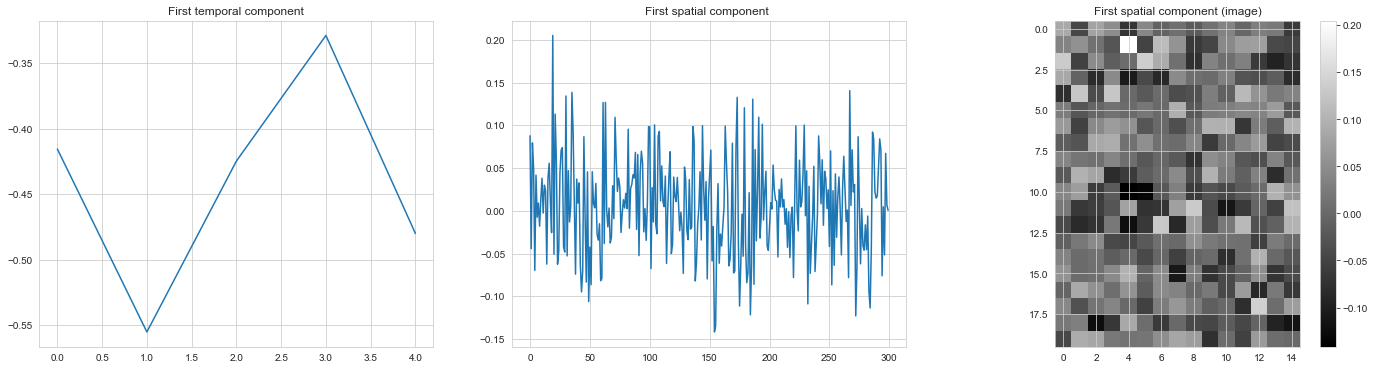

In [50]:
U,S,Vh = np.linalg.svd(w_est)

plt.figure(figsize=(24,6))
plt.subplot(1,3,1)
plt.plot(U[:,0])
plt.title("First temporal component")

plt.subplot(1,3,2)
plt.plot(Vh[0,:])
plt.title("First spatial component ")

plt.subplot(1,3,3)
plt.imshow( Vh[0,:].reshape((20,15)), cmap='gray')
plt.colorbar()
plt.title("First spatial component (image)")

plt.show()

## Task 4: Regularized receptive field

As you can see, maximum likelihood estimation of linear receptive fields can be quite noisy, if little data is available. 

To improve on this, one can regularize the receptive field vector and a term to the cost function


$$
C(w) = L(w) + \alpha ||w||_p^2
$$

Here, the $p$ indicates which norm of $w$ is used: for $p=2$, this is shrinks all coefficient equally to zero; for $p=1$, it favors sparse solutions, a penality also known as lasso. Because the 1-norm is not smooth at zero, it is not as straightforward to implement "by hand". 

Use a toolbox with an implementation of the lasso-penalization and fit the receptive field. Possibly, you will have to try different values of the regularization parameter $\alpha$. Plot your estimates from above and the lasso-estimates. How do they differ? What happens when you increase or decrease $alpha$?

If you want to keep the Poisson noise model, you can use the implementation in [`pyglmnet`](https://pypi.python.org/pypi/pyglmnet). Otherwise, you can also resort to the linear model from `sklearn` which assumes Gaussian noise (which in my hands was much faster).

*Grading: 2 pts*


__Lasso-penalization supress noises. Without regularization, the first spatial component are very noisy. Alpha represents the regularization strength. As alpha increases, noise decrease in the fitted receptive field as well as its first spatial component. But if alpha is too big, it will also supress the signal coefficients to 0.__

In [19]:
 from sklearn.linear_model import Lasso

In [20]:
 # enter fitting code here
w_lasso=[]
alpha = [0.01,0.05,0.1]
for a in alpha:
    clf = Lasso(alpha=a)       
    clf.fit(ss.T,cc)
    w_lasso.append(clf.coef_)
    for i in range(1,5):
        # use the update s and c
        clf.fit(ss[:,:-i].T,cc[i:]) 
        w_lasso.append(clf.coef_)
w_plot = w_est+w_lasso
    
    

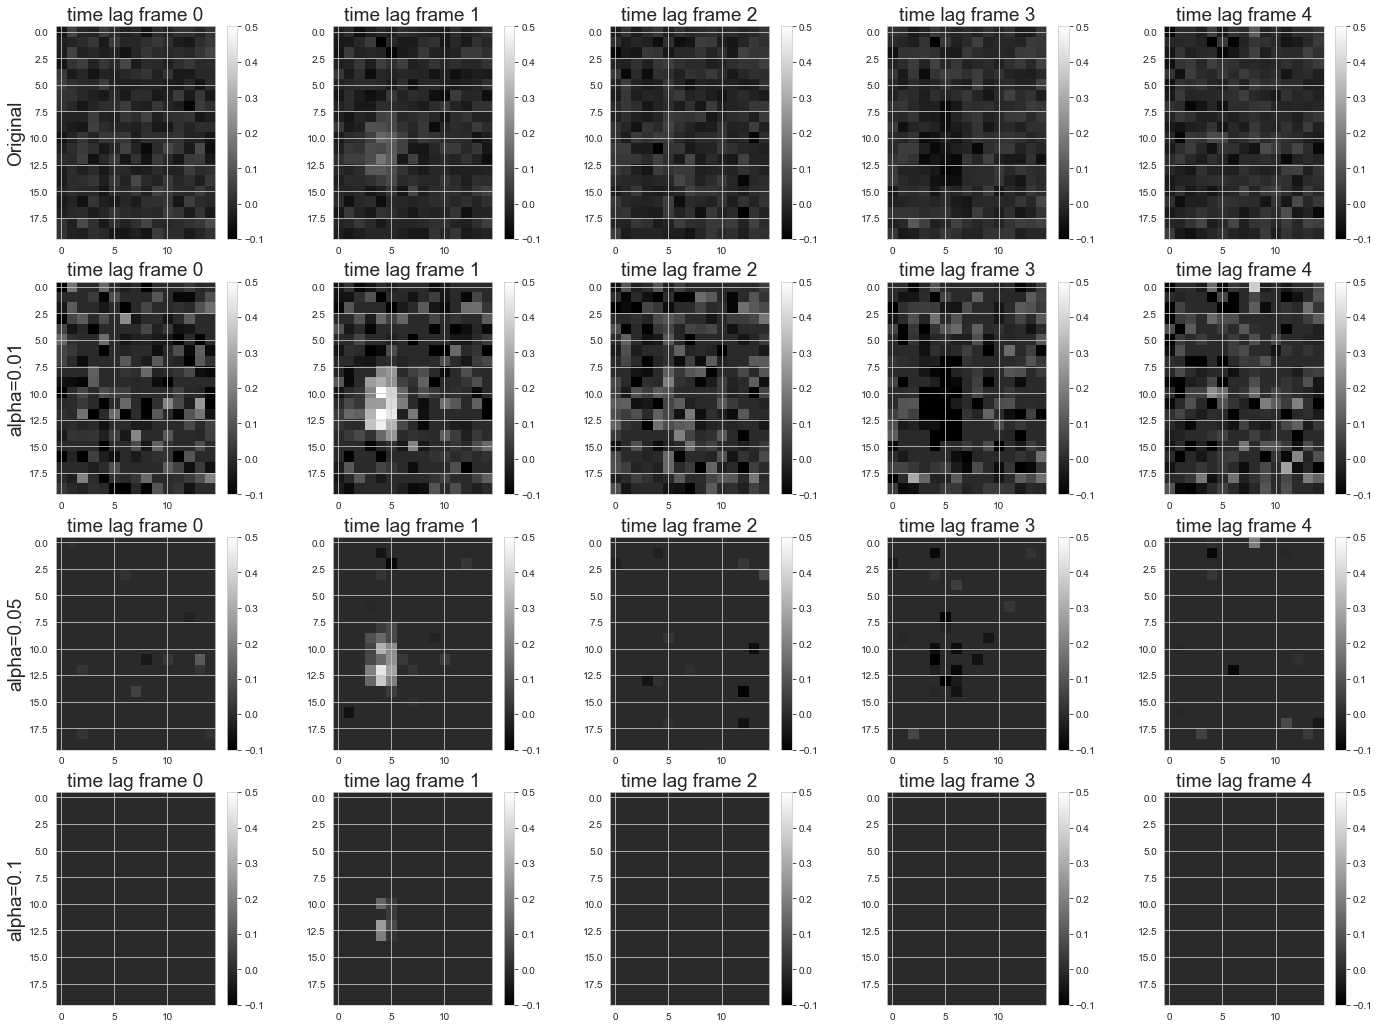

In [51]:
plt.figure(figsize=(24,18))
ylist=['Original','alpha=0.01','alpha=0.05','alpha=0.1']
for i in range(len(w_plot)):
    plt.subplot(len(alpha)+1,5,i+1)
    plt.imshow(np.reshape(w_plot[i], (20,15)),cmap='gray',vmin=-0.1,vmax=0.5)  
    plt.title('time lag frame '+str(i%5),fontsize=19)
    if i%5 ==0:
        plt.ylabel(ylist[int(i/5)],fontsize=19)
    plt.colorbar()



In [22]:
U_list=[]
Vh_list=[]
for i in range(4):
    U,S,Vh = np.linalg.svd(w_plot[i*5:i*5+5])
    U_list.append(U)
    Vh_list.append(Vh)


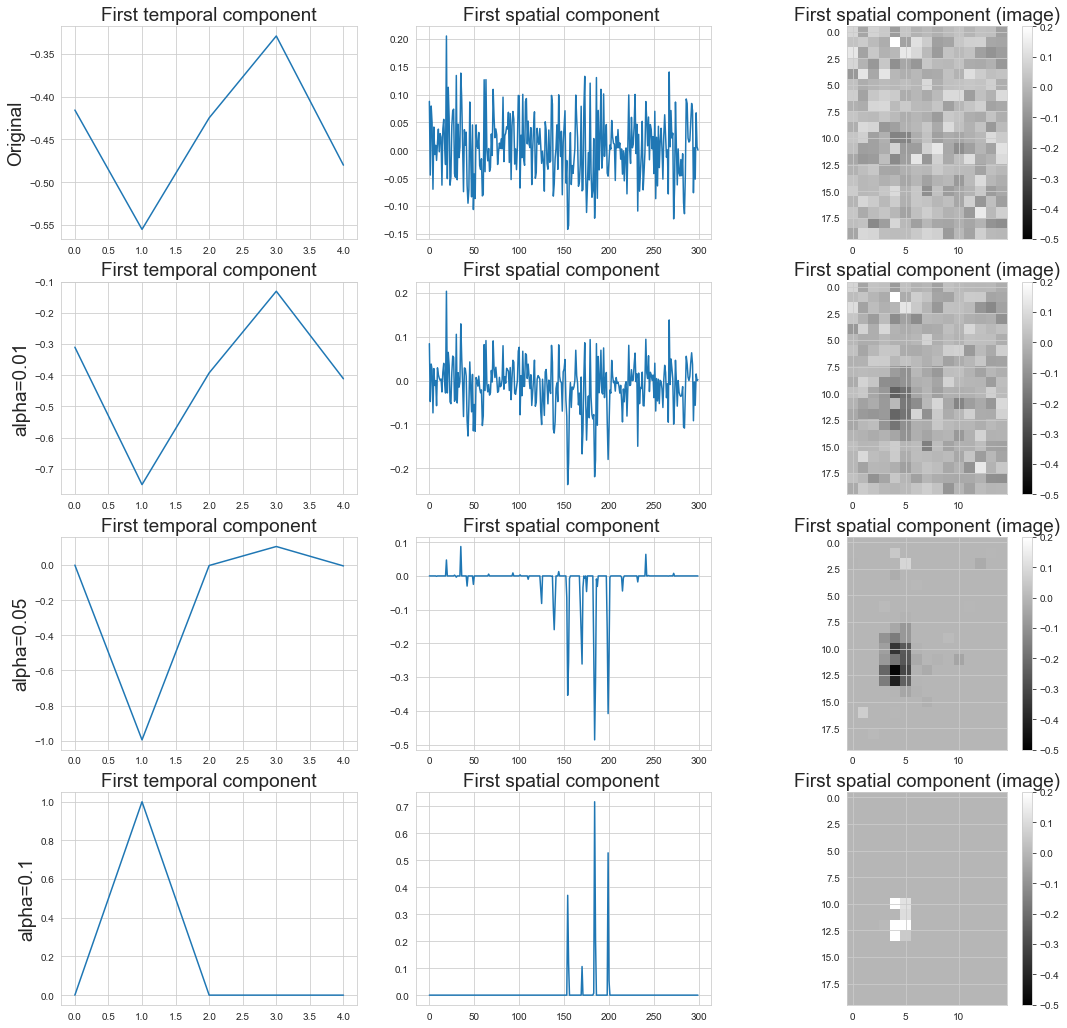

In [52]:
plt.figure(figsize=(18,18))
for i in range(4):
    plt.subplot(4,3,3*i+1)
    plt.plot(U_list[i][:,0])
    plt.title("First temporal component",fontsize=19)
    plt.ylabel(ylist[i],fontsize=19)
    
    plt.subplot(4,3,3*i+2)
    plt.plot(Vh_list[i][0,:])
    plt.title("First spatial component ",fontsize=19)

    plt.subplot(4,3,3*i+3)
    plt.imshow(Vh_list[i][0,:].reshape((20,15)),cmap='gray',vmin=-0.5,vmax=0.2)
    plt.colorbar()
    plt.title("First spatial component (image)",fontsize=19)

plt.show()